## Homework 02

In this notebook you'll explore, train, and evaluate models on the FashionMNIST dataset.  FashionMNIST was set up as a more difficult drop-in replacement for MNIST.

For this assigment you'll want to use a CoCalc compute server with GPU.  Make sure you've watched the video at the beginning of the lesson about compute servers.

#### Class Package, imports, and configurations

In [1]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../../Lessons/Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [2]:
# imports and configuration

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

import torchvision.transforms.v2 as transforms
from torchvision.datasets import FashionMNIST

from introdl.utils import get_device, load_results, load_model, summarizer, config_paths_keys
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, vis_feature_maps, vis_feature_maps_widget, interactive_mnist_prediction
from introdl.visul import evaluate_classifier, create_image_grid

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

device = get_device()

MODELS_PATH=.
DATA_PATH=.
TORCH_HOME=.
HF_HOME=.


### Warmup (5 points)

Train LeNet5Rev on FashionMNIST and evaluate the performance on the test set.  Include convergence plots of loss and accuracy on the training and test data.

#### Setup Data

In [3]:
# Initial load to determine dataset mean and std
dataset = FashionMNIST(root=DATA_PATH, download=True)
mean = (dataset.data.float().mean().item()/255,)
std = (dataset.data.float().std().item()/255,)

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean,std),
])

# Training Data
train_dataset = FashionMNIST(root=DATA_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Test Data
test_dataset = FashionMNIST(root=DATA_PATH, train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [5]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.2860406015433517], std=[0.35302426207299326], inplace=False)
           )

#### Explore Data

In [ ]:
create_image_grid(test_dataset, 5, 10, cmap='gray', dark_mode=True)


x,y=next(iter(train_loader))
print(x.shape)

#### LeNet5Rev model

In [208]:
class LeNet5Rev(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

In [ ]:
# model summary
model = LeNet5Rev()
summarizer(model, input_size = (64,1,28,28))

#### Train Model

In [209]:
model = LeNet5Rev()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### View Model Performance

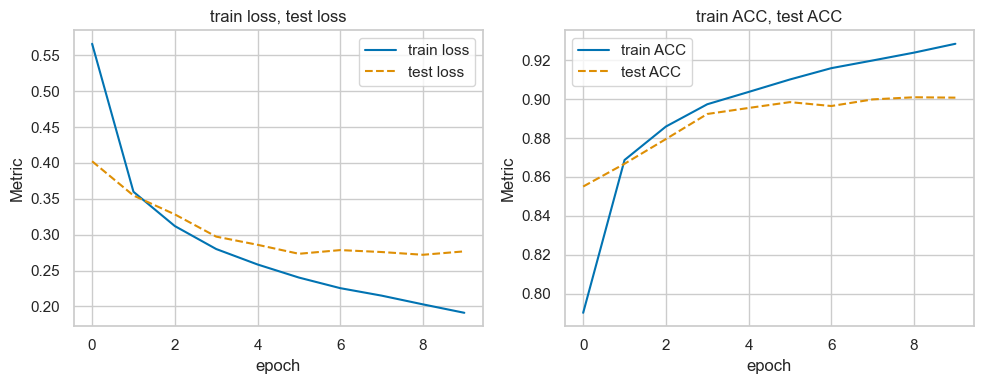

In [8]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

Model is overfitting training data

### Improve the model (24 pts)

Try increasing the number of convolutional layers up to six with ReLU layers.  You many need to increase
the number of channels (but not in every layer).  Use two max pooling layers.  Kernel size can be 3 or 5
but adjust the padding so that the convolutional layers preserve the size of the feature maps.

You can also simplify the classifier.  Try a single linear layer instead of multiple linear layers
separated by ReLU functions.

You should be able to achieve about 92% accuracy on the test set.  Show convergence plots for each model you try.   

You should try at least three different models.  Describe your experiments.  For each experiment include the model and plot convergence results.  

#### Improved Model 1

##### Model

In [214]:
class LeNet5Rev_NK_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28*28->14*14


            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),  # 28*28->28*28
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),  # 14*14->14*14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1),  # 14*14->12*12
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2, stride=2),  # 12*12->6*6

            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*6*6, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

In [215]:
# model summary
model = LeNet5Rev_NK_1()
summarizer(model, input_size = (64,1,28,28))

Layer (type (var_name))                  Input Shape          Output Shape         Param #
LeNet5Rev_NK_1 (LeNet5Rev_NK_1)          [64, 1, 28, 28]      [64, 10]             --
├─Sequential (cnn_layers)                [64, 1, 28, 28]      [64, 16, 6, 6]       --
│    └─Conv2d (0)                        [64, 1, 28, 28]      [64, 32, 28, 28]     832
│    └─ReLU (1)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─Conv2d (2)                        [64, 32, 28, 28]     [64, 32, 28, 28]     25,632
│    └─ReLU (3)                          [64, 32, 28, 28]     [64, 32, 28, 28]     --
│    └─MaxPool2d (4)                     [64, 32, 28, 28]     [64, 32, 14, 14]     --
│    └─Conv2d (5)                        [64, 32, 14, 14]     [64, 32, 14, 14]     9,248
│    └─ReLU (6)                          [64, 32, 14, 14]     [64, 32, 14, 14]     --
│    └─Conv2d (7)                        [64, 32, 14, 14]     [64, 16, 14, 14]     4,624
│    └─ReLU (8)                       

##### Train Model

In [216]:
model = LeNet5Rev_NK_1()

loss_func = nn.CrossEntropyLoss() # classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = get_device() # doing locally with mps

ckpt_file = MODELS_PATH / 'HW02_FashionMNIST_LeNet5Rev_NK_1.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}


results_FashionMNIST_LeNet5Rev_NK_1 = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file,
                                    pretend_train=False)


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

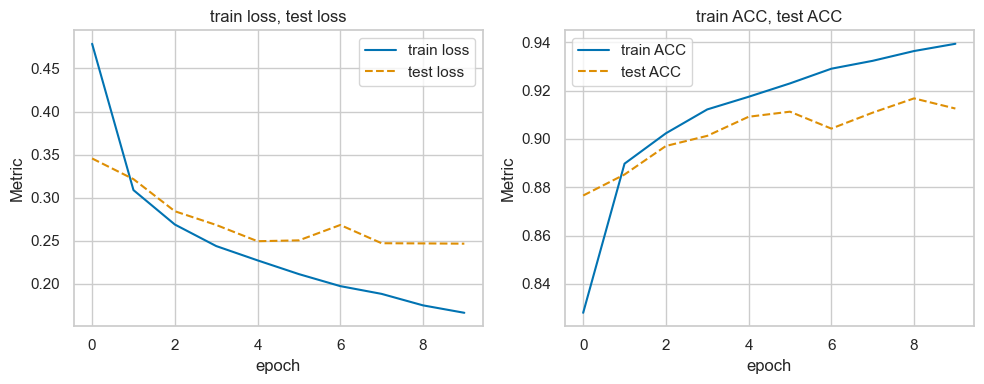

In [217]:
plot_training_metrics(results_FashionMNIST_LeNet5Rev_NK_1,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

In [176]:
results_FashionMNIST_LeNet5Rev_NK_1

,epoch,total time,train loss,test loss,train ACC,test ACC
0,0,26.034772,0.515481,0.384368,0.811517,0.8611
1,1,52.515481,0.321422,0.313074,0.883833,0.8862
2,2,78.923189,0.276274,0.303243,0.900167,0.8892
3,3,105.980250,0.246425,0.279129,0.911300,0.8984
4,4,132.397999,0.222080,0.257855,0.919417,0.9034
5,5,158.304644,0.205194,0.251431,0.925100,0.9078
6,6,184.285586,0.189137,0.239444,0.931133,0.9147
7,7,210.540666,0.177363,0.248678,0.934767,0.9135
8,8,237.119774,0.165713,0.243919,0.938217,0.9142
9,9,263.124368,0.154069,0.252023,0.943717,0.9107


### Describe the things you tried (3 pts)

Summarize the network architectures you tried.  What worked best?  What didn't help?

### Analyze your best model (8 pts)

Make a confusion matrix for the predictions of your best model on the test set.  You can set `use_class_labels = True` when using `evaluate_classifier` to see the names of the classes.  You can also access the names of the classes as an attribute of the dataset, e.g. `dataset.classes`.

Describe which classes get most confused by your model.  Plot examples of the images that your model is getting wrong.  Do these misclassifications make sense?  Are the images from the misclassified classes hard to distinguish by eye?